In [1]:
## Import necessary Liabraries

import warnings
warnings.filterwarnings('ignore')
import seaborn                   as sns
import numpy                     as np
import pandas                    as pd
import scipy.stats               as stats
from scipy.stats.mstats          import kruskalwallis
from scipy.stats                 import ttest_1samp,ttest_ind, wilcoxon, shapiro, levene,mannwhitneyu
from statsmodels.stats.power     import ttest_power
import matplotlib.pyplot         as     plt
from statsmodels.formula.api     import ols      # For n-way ANOVA
from statsmodels.stats.anova     import anova_lm # For n-way ANOVA
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from scipy.stats import zscore
from statsmodels.multivariate.factor import Factor
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from statsmodels.multivariate.pca import PCA
from sklearn import preprocessing

# Problem 1 :

**A research laboratory was developing a new compound for the relief of severe cases of hay fever. In an experiment with 36 volunteers, the amounts of the two active ingredients (A & B) in the compound were varied at three levels each. Randomization was used in assigning four volunteers to each of the nine treatments. The data on hours of relief can be found in the following .csv file: Fever.csv**

In [2]:
## Read the file

fever = pd.read_csv("Fever.csv")
fever.head(3)

,A,B,Volunteer,Relief
0,1,1,1,2.4
1,1,1,2,2.7
2,1,1,3,2.3


In [3]:
fever.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
A            36 non-null int64
B            36 non-null int64
Volunteer    36 non-null int64
Relief       36 non-null float64
dtypes: float64(1), int64(3)
memory usage: 1.2 KB


In [4]:
#to see statistical metrics
fever.describe()

,A,B,Volunteer,Relief
count,36.000000,36.000000,36.000000,36.000000
mean,2.000000,2.000000,2.500000,7.183333
std,0.828079,0.828079,1.133893,3.272090
min,1.000000,1.000000,1.000000,2.300000
25%,1.000000,1.000000,1.750000,4.675000
50%,2.000000,2.000000,2.500000,6.000000
75%,3.000000,3.000000,3.250000,9.325000
max,3.000000,3.000000,4.000000,13.500000


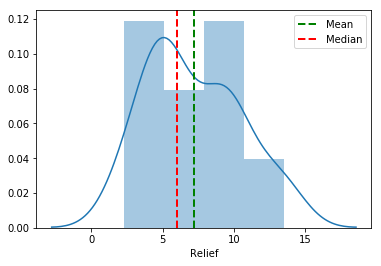

In [5]:
sns.distplot(fever["Relief"])
plt.axvline(fever["Relief"].mean(), linestyle='dashed', linewidth=2,c="g",label="Mean")
plt.axvline(fever["Relief"].median(), linestyle='dashed', linewidth=2,c="r",label="Median")
plt.legend()
plt.show()

In [6]:
#to see individual counts
for i in fever.columns.values.tolist():
    print(i,fever[i].unique())
    print(fever[i].value_counts())

A [1 2 3]
3    12
2    12
1    12
Name: A, dtype: int64
B [1 2 3]
3    12
2    12
1    12
Name: B, dtype: int64
Volunteer [1 2 3 4]
4    9
3    9
2    9
1    9
Name: Volunteer, dtype: int64
Relief [ 2.4  2.7  2.3  2.5  4.6  4.2  4.9  4.7  4.8  4.5  4.4  5.8  5.2  5.5
  5.3  8.9  9.1  8.7  9.   9.3  9.4  6.1  5.7  5.9  6.2  9.9 10.5 10.6
 10.1 13.5 13.  13.3 13.2]
9.1     2
8.7     2
4.6     2
5.8     1
4.9     1
4.5     1
5.5     1
9.0     1
10.5    1
5.2     1
6.2     1
13.5    1
10.6    1
13.0    1
4.4     1
10.1    1
8.9     1
9.9     1
2.3     1
2.7     1
5.3     1
4.7     1
5.9     1
6.1     1
9.4     1
13.2    1
9.3     1
2.4     1
4.2     1
5.7     1
13.3    1
4.8     1
2.5     1
Name: Relief, dtype: int64


In [7]:
pd.pivot_table(fever, values="Volunteer", index=['B'],
               columns=['A'], aggfunc="count")

A,1,2,3
B,,,
1,4,4,4
2,4,4,4
3,4,4,4


**1.1) State the Null and Alternate Hypothesis for conducting one-way ANOVA for both the variables ‘A’ and ‘B’ individually.**

**Ingredient A -**

**H0 : The mean relief from hay fever among volunteers when Ingredient A is administered at three different levels is equal.** 

**MuA1 = MuA2 = MuA3**
       
**H1 : The mean relief from hay fever among volunteers when Ingredient A is administered at three different levels is not equal for atleast one pair of groups.**  

**The group means are not equal (!=) for atleast one pair of groups MuA1 / MuA2 / MuA3**
       

**Ingredient B -**

**H0 : The mean relief from hay fever among volunteers when Ingredient B is administered at three different levels is equal.** 

**MuB1 = MuB2 = MuB3**
       
**H1 : The mean relief from hay fever among volunteers when Ingredient B is administered at three different levels is not equal for atleast one pair of groups.** 

**The group means are not equal (!=) for atleast one pair of groups MuB1 / MuB2 / MuB3**
        

**1.2) Perform one-way ANOVA for variable ‘A’ with respect to the variable ‘Relief’. State whether the Null Hypothesis is accepted or rejected based on the ANOVA results.**

In [8]:
fever['A'] = pd.Categorical(fever['A']) ## Converting Ingrdient A from dataypte Integer to Category

In [9]:
fever.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
A            36 non-null category
B            36 non-null int64
Volunteer    36 non-null int64
Relief       36 non-null float64
dtypes: category(1), float64(1), int64(2)
memory usage: 1.1 KB


In [10]:
A1=fever.loc[fever['A']==1]['Relief'] 
A2=fever.loc[fever['A']==2]['Relief'] 
A3=fever.loc[fever['A']==3]['Relief'] 

In [11]:
Ing_A_means=fever.groupby('A').mean()['Relief']
Ing_A_means

A
1    3.883333
2    7.833333
3    9.833333
Name: Relief, dtype: float64

**Visual Check of Normality of distribution for the three levels A1, A2, A3 of Ingredient A.**

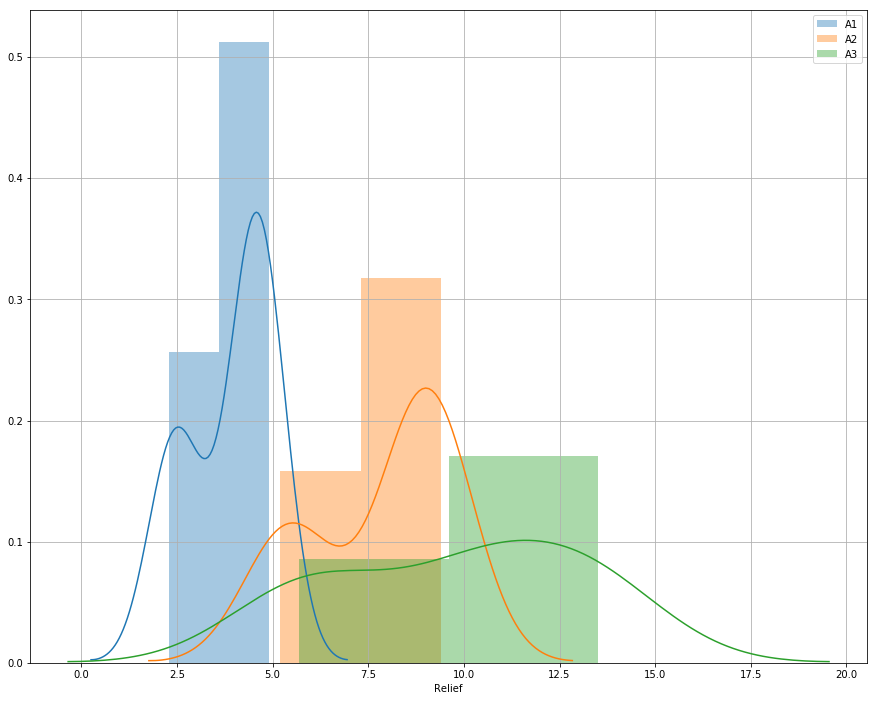

In [50]:
sns.distplot(fever.loc[fever['A'] == 1]['Relief'])
sns.distplot(fever.loc[fever['A'] == 2]['Relief'])
sns.distplot(fever.loc[fever['A'] == 3]['Relief'])
plt.legend(['A1','A2','A3'])
plt.grid()
plt.show()



**Shapiro Test to check for Normality of Data for Ingredient A.** 

H0 - Data for the three levels of Ingredient A are Normal

H1 - Data for the three levels of Ingredient A are not Normal.

In [13]:
ftestA1,pvalueA1 = shapiro(A1)
ftestA2,pvalueA2 = shapiro(A2)
ftestA3,pvalueA3 = shapiro(A3)
print('The Shapiro pvalue for A1 level of Ingredient A is', pvalueA1)
print('The Shapiro pvalue for A2 level of Ingredient A is', pvalueA2)
print('The Shapiro pvalue for A3 level of Ingredient A is', pvalueA3)

The Shapiro pvalue for A1 level of Ingredient A is 0.004211828112602234
The Shapiro pvalue for A2 level of Ingredient A is 0.001616060733795166
The Shapiro pvalue for A3 level of Ingredient A is 0.03468279168009758


The Visual check as well as the Shapiro test conducted conclude that the pvalue for all the three levels (A1,A2,A3) of Ingredient A are less than 0.05. 

Hence we reject H0 and conclude that Data is not Normally distributed for the three levels of Ingredient A.

**Visual Check of Equality Of Variance for Ingredient A.**

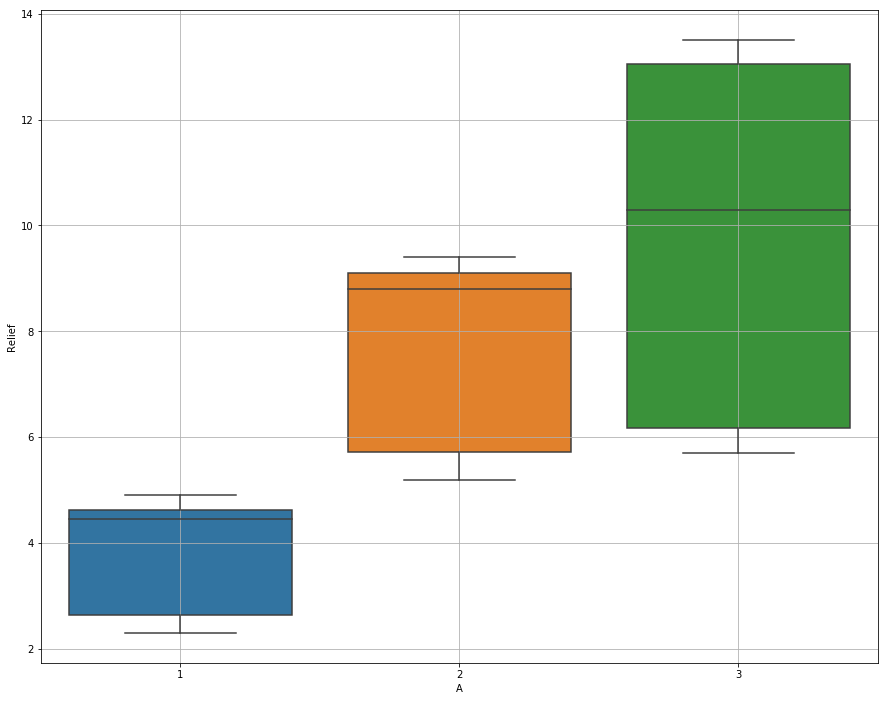

In [42]:
sns.boxplot(fever['A'], fever['Relief']);
plt.grid()

**Levenes Test to check for Equality of Variance for Ingredient A** 

H0 - Variance of the Variants A1,A2 and A3 for Ingredient A are not significantly different from each other

H1 - Variance of the Variants A1,A2 and A3 for Ingredient A significantly different from each other


In [15]:
print('The Levenes test pvalue for the three levels of Ingredient A is',(levene(A1,A2,A3).pvalue))

The Levenes test pvalue for the three levels of Ingredient A is 0.018535088623493387


From the Visual Check as well as the Levenes test conducted to check the equality of variance for the three levels (A1, A2, A3) of Ingredient A we can observe the pvalue is less than 0.05, hence we reject H0. 

We can conclude that the variances of the three levels of Ingredient A differ significantly from each Other.

In [43]:
kruskalwallis(np.array(fever.loc[fever['A']==1]['Relief']),
              np.array(fever.loc[fever['A']==2]['Relief']),
              np.array(fever.loc[fever['A']==3]['Relief']))

KruskalResult(statistic=25.645036693704128, pvalue=2.6992992738200464e-06)

In [44]:
formula = 'Relief ~ C(A) '
model = ols(formula, fever).fit()
aov_table = anova_lm(model)
print(aov_table)

            df  sum_sq     mean_sq          F        PR(>F)
C(A)       2.0  220.02  110.010000  23.465387  4.578242e-07
Residual  33.0  154.71    4.688182        NaN           NaN


Due to failure of both the Normality and Equality of Variances assumptions we have gone in for the Non Parametric Kruskalwallis Test. The pvalue returned by this test is less than 0.05, hence we reject the H0.

The question explicitly ask for a one way ANOVA to be performed for variable ‘A’ with respect to the variable ‘Relief’.
The oneway ANOVA pvalue is less than 0.05, hence we reject the H0.


**We can conclude that the mean relief from hay fever among volunteers when the three levels of Ingredient A is administered is not equal for atleast one or more levels.**

To find out which of the means differs we conduct Tukey HSD Test.

In [45]:
mc = MultiComparison(fever['Relief'] , fever['A'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      2      3.95    1.7814 6.1186  True 
  1      3      5.95    3.7814 8.1186  True 
  2      3      2.0    -0.1686 4.1686 False 
--------------------------------------------
[1 2 3]


## Tukey HSD Interpretation - 

We can conclude that the group means for Level A1 - LevelA2 and Level A1 - LevelA3 are not equal.

**1.3) Perform one-way ANOVA for variable ‘B’ with respect to the variable ‘Relief’. State whether the Null Hypothesis is accepted or rejected based on the ANOVA results.**

In [46]:
fever['B'] = pd.Categorical(fever['B']) ## Converting Ingrdient B from dataypte Integer to Category

In [47]:
fever.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
A            36 non-null category
B            36 non-null category
Volunteer    36 non-null int64
Relief       36 non-null float64
dtypes: category(2), float64(1), int64(1)
memory usage: 936.0 bytes


In [21]:
B1=fever.loc[fever['B']==1]['Relief'] 
B2=fever.loc[fever['B']==2]['Relief'] 
B3=fever.loc[fever['B']==3]['Relief'] 

In [48]:
Ing_B_means=fever.groupby('B').mean()['Relief']
Ing_B_means

B
1    4.633333
2    7.933333
3    8.983333
Name: Relief, dtype: float64

**Visual Check of Normality of distribution of Ingredient B.**

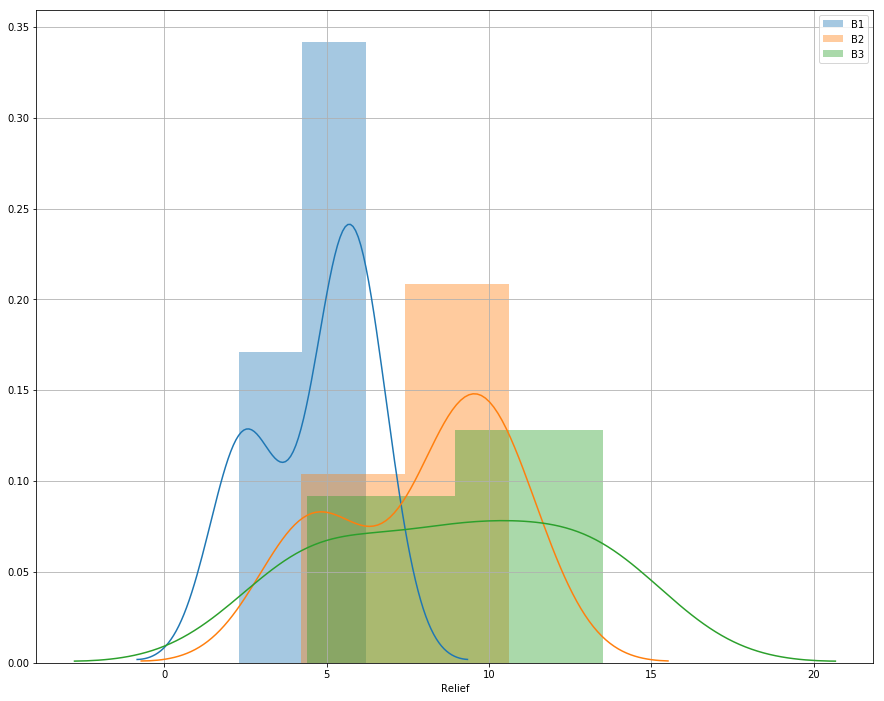

In [49]:
sns.distplot(fever.loc[fever['B'] == 1]['Relief'])
sns.distplot(fever.loc[fever['B'] == 2]['Relief'])
sns.distplot(fever.loc[fever['B'] == 3]['Relief'])
plt.legend(['B1','B2','B3'])
plt.grid()
plt.show()



**Shapiro Test to check for Normality of Data for Ingredient B.** 

H0 - Data for the three levels of Ingredient B are Normal

H1 - Data for the three levels of Ingredient B are not Normal.

In [24]:
ftestB1,pvalueB1 = shapiro(B1)
ftestB2,pvalueB2 = shapiro(B2)
ftestB3,pvalueB3 = shapiro(B3)
print('The Shapiro pvalue for B1 level of Ingredient B is', pvalueB1)
print('The Shapiro pvalue for B2 level of Ingredient B is', pvalueB2)
print('The Shapiro pvalue for B3 level of Ingredient B is', pvalueB3)

The Shapiro pvalue for B1 level of Ingredient B is 0.003910908009856939
The Shapiro pvalue for B2 level of Ingredient B is 0.01112875435501337
The Shapiro pvalue for B3 level of Ingredient B is 0.031581711024045944


From the Shapiro test conducted we can conclude that the pvalue for all the three variants (B1,B2,B3) of Ingredient B are less than 0.05. Hence we reject H0 and conclude that Data is not Normally distributed for the three levels of Ingredient B.

**Levenes Test to check for Equality of Variance for Ingredient B** 

H0 - Variance of the Variants B1,B2 and B3 for Ingredient B are not significantly different from each other

H1 - Variance of the Variants B1,B2 and B3 for Ingredient B significantly different from each other


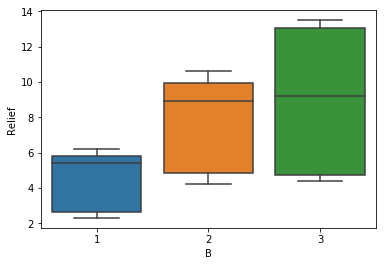

In [25]:
sns.boxplot(fever['B'], fever['Relief']);

In [26]:
print('The Levenes test pvalue for Ingredient B is',(levene(B1,B2,B3).pvalue))

The Levenes test pvalue for Ingredient B is 0.06675699295483081


From the Levenes test conducted to check the euqlity of variance for the three variants ( B1, B2, B3) of Ingredient B we can observe the pvalue is more than 0.05, hence we fail to rejct H0. We can conclude that the variances of the three variants of Ingredient B are not significantly different from each Other.

**ANOVA IS ROBUST TO THE VIOLATION OF NORMALITY ASSUMTION PROVIDED THE VARIANCES OF THE GROUPS ARE EQUAL.** Hence we proceed with one way Anova for Ingredient B.

In [27]:
formula = 'Relief ~ C(B) '
model = ols(formula, fever).fit()
aov_table = anova_lm(model)
print(aov_table)

            df  sum_sq    mean_sq         F   PR(>F)
C(B)       2.0  123.66  61.830000  8.126777  0.00135
Residual  33.0  251.07   7.608182       NaN      NaN


The one way ANOVA for variable ‘B’ with respect to the variable ‘Relief’ returns a pvalue less than 0.05, hence we reject the H0.


**We can conclude that the mean relief from hay fever among volunteers when the three levels of Ingredient B is administered is not equal for atleast one or more levels.**

To find out which of the means differs we conduct Tukey HSD Test.


In [28]:
mc = MultiComparison(fever['Relief'], fever['B'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      2      3.3     0.5374 6.0626  True 
  1      3      4.35    1.5874 7.1126  True 
  2      3      1.05   -1.7126 3.8126 False 
--------------------------------------------
[1 2 3]


## Tukey HSD Interpretation - 

We can conclude that the group means for Level B1 - Level B2 and Level B1 - Level B3 are not equal.

**1.4) Analyse the effects of one variable on another with the help of an interaction plot. 
What is the interaction between the two treatments?
[hint: use the ‘pointplot’ function from the ‘seaborn’ function]**

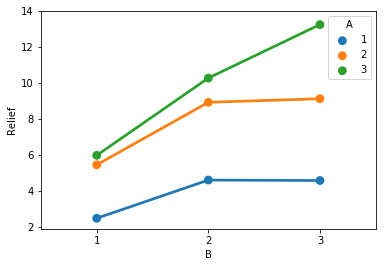

In [29]:
sns.pointplot(x='B', y = 'Relief', data= fever, hue='A', ci = True)

# Interpretation of the Point Plot to visualise Interactivity.

When the lines of a point plot run parallel and do not intersect there is no visible interaction. We can see that there is no interaction between any of the three levels of the two Ingredients.

When levels B1 is combined with A1 , A2 and A3 levels, we observe that the relief factor is hightest for the combination of B1 and A3 levels. 

When levels B2 is combined with A1 , A2 and A3 levels, we observe that the relief factor is hightest for the combination of B2 and A3 levels. 

When levels B3 is combined with A1 , A2 and A3 levels, we observe that the relief factor is hightest for the combination of B3 and A3 levels. 

The best combination in relief is the highest for the combination of B3 - A3 Levels.

In [30]:
formula = 'Relief ~ C(A) + C(B) + C(A) : C(B) '
model = ols(formula, fever).fit()
aov_table = anova_lm(model)
print(aov_table)

             df   sum_sq     mean_sq            F        PR(>F)
C(A)        2.0  220.020  110.010000  1827.858462  1.514043e-29
C(B)        2.0  123.660   61.830000  1027.329231  3.348751e-26
C(A):C(B)   4.0   29.425    7.356250   122.226923  6.972083e-17
Residual   27.0    1.625    0.060185          NaN           NaN


As seen in the point plot and also the pvalue obtained from the ANOVA formula is less that 0.05, we conclude that there is no interaction of the two Ingredients A and B. 

**1.5) Perform a two-way ANOVA based on the different ingredients (variable ‘A’ & ‘B’) with the variable 'Relief' and state your results.**

In [51]:
formula = 'Relief ~ C(A) + C(B) '
model = ols(formula, fever).fit()
aov_table = anova_lm(model)
print(aov_table)

            df  sum_sq     mean_sq           F        PR(>F)
C(A)       2.0  220.02  110.010000  109.832850  8.514029e-15
C(B)       2.0  123.66   61.830000   61.730435  1.546749e-11
Residual  31.0   31.05    1.001613         NaN           NaN


There is no significant impact on the Relief variable either by the three levels in Ingredients A and B individually or by the Interaction of these two Ingredients. The pvalues in both the cases is less  than 0.05 , hence we Reject the H0.

**We can Conclude that the mean relief from hay fever among volunteers when Ingredient A and B is administered at three different levels is not equal.**

**1.6) Mention the business implications of performing ANOVA for this particular case study.**

Here the company is trying to develop a new compound using Ingredients A and B in three varied levels, using hours of Relief as the efficacy (how well it works) parameter.  

The One way Anova test indicates that ingredient A and ingredient B individually do not have a signifiant impact on the hours of Relief among the volunteers.
The two way Anova with interaction effect also incicates the same that ingredient A and ingredient B individually and when administered in combination do have a significat impact on the hours of relief among volunteers. This is also validated by the pvalues of the Anova test which are all below 0.05, concluding that we have rejected the H0.

**Recomendations -**

The hours of relief is the highest for the combination of A3 - B3 Levels as seen in the Point Plot. This being the case the company can review the cost involved in the production of the compound in this combination and look at making the same available in the market.
A good idea would be to confirm the same by conducting a study of a sample with this combination before mass production.  

# PROBLEM 2:

A company performed a survey to understand the income of households in various neighbourhoods of a country. The data dictionary is also present. You can access the data dictionary from the following file Income_Data Dictionary. Please refer to the following data set to solve the problem Income.csv. ['FamilyIncome' is the target variable]

In [54]:
income = pd.read_csv('Income.csv')
income.head()

,WorkingHoursWife,WifeAge,EducationWife,WifeHourEarnings,WifeWage,WorkingHoursHusband,HusbandAge,EducationHusband,HusbandWage,EducationWifeMother,EducationWifeFather,UnemploymentRate,WifeExperience,FamilyIncome
0,1610,32,12,3.3540,2.65,2708,34,12,4.0288,12,7,5.0,14,16310
1,1656,30,12,1.3889,2.65,2310,30,9,8.4416,7,7,11.0,5,21800
2,1980,35,12,4.5455,4.04,3072,40,12,3.5807,12,7,5.0,15,21040
3,456,34,12,1.0965,3.25,1920,53,10,3.5417,7,7,5.0,6,7300
4,1568,31,14,4.5918,3.60,2000,32,12,10.0000,12,14,9.5,7,27300


In [55]:
print(income.info(),'\n')
print(income.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 14 columns):
WorkingHoursWife       753 non-null int64
WifeAge                753 non-null int64
EducationWife          753 non-null int64
WifeHourEarnings       753 non-null float64
WifeWage               753 non-null float64
WorkingHoursHusband    753 non-null int64
HusbandAge             753 non-null int64
EducationHusband       753 non-null int64
HusbandWage            753 non-null float64
EducationWifeMother    753 non-null int64
EducationWifeFather    753 non-null int64
UnemploymentRate       753 non-null float64
WifeExperience         753 non-null int64
FamilyIncome           753 non-null int64
dtypes: float64(4), int64(10)
memory usage: 82.4 KB
None 

WorkingHoursWife         int64
WifeAge                  int64
EducationWife            int64
WifeHourEarnings       float64
WifeWage               float64
WorkingHoursHusband      int64
HusbandAge               int64
EducationHusband       

In [56]:
income.isnull().sum()

WorkingHoursWife       0
WifeAge                0
EducationWife          0
WifeHourEarnings       0
WifeWage               0
WorkingHoursHusband    0
HusbandAge             0
EducationHusband       0
HusbandWage            0
EducationWifeMother    0
EducationWifeFather    0
UnemploymentRate       0
WifeExperience         0
FamilyIncome           0
dtype: int64

In [57]:
income.describe()

,WorkingHoursWife,WifeAge,EducationWife,WifeHourEarnings,WifeWage,WorkingHoursHusband,HusbandAge,EducationHusband,HusbandWage,EducationWifeMother,EducationWifeFather,UnemploymentRate,WifeExperience,FamilyIncome
count,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.00000,753.000000
mean,740.576361,42.537849,12.286853,2.374565,1.849734,2267.270916,45.120850,12.491368,7.482179,9.250996,8.808765,8.623506,10.63081,23080.594954
std,871.314216,8.072574,2.280246,3.241829,2.419887,595.566649,8.058793,3.020804,4.230559,3.367468,3.572290,3.114934,8.06913,12190.202026
min,0.000000,30.000000,5.000000,0.000000,0.000000,175.000000,30.000000,3.000000,0.412100,0.000000,0.000000,3.000000,0.00000,1500.000000
25%,0.000000,36.000000,12.000000,0.000000,0.000000,1928.000000,38.000000,11.000000,4.788300,7.000000,7.000000,7.500000,4.00000,15428.000000
50%,288.000000,43.000000,12.000000,1.625000,0.000000,2164.000000,46.000000,12.000000,6.975800,10.000000,7.000000,7.500000,9.00000,20880.000000
75%,1516.000000,49.000000,13.000000,3.787900,3.580000,2553.000000,52.000000,15.000000,9.166700,12.000000,12.000000,11.000000,15.00000,28200.000000
max,4950.000000,60.000000,17.000000,25.000000,9.980000,5010.000000,60.000000,17.000000,40.509000,17.000000,17.000000,14.000000,45.00000,96000.000000


**2.1) Perform exploratory data analysis on the dataset. Showcase some charts, graphs.**

In [58]:
from pylab import rcParams

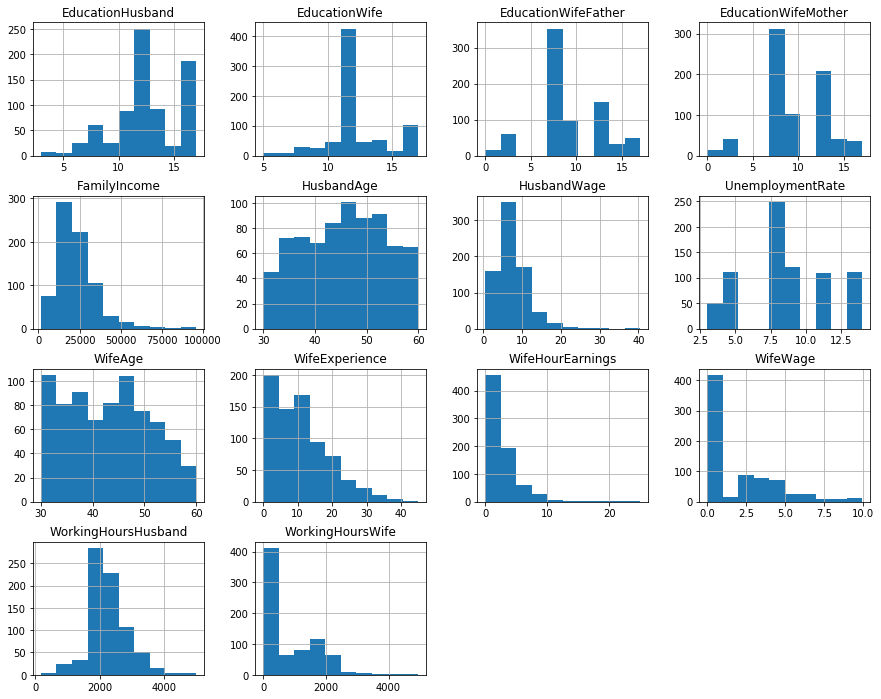

In [53]:
rcParams['figure.figsize'] = 15, 12

income.hist();

Not all the parameters are normally distributed, some are bimodal as we can see from the above histograms. This is a sample from a large population , as long as the sample size is more than 30 Wwe assume that CLT (Central Limit Theorem) holds true and the data is normally distributed.

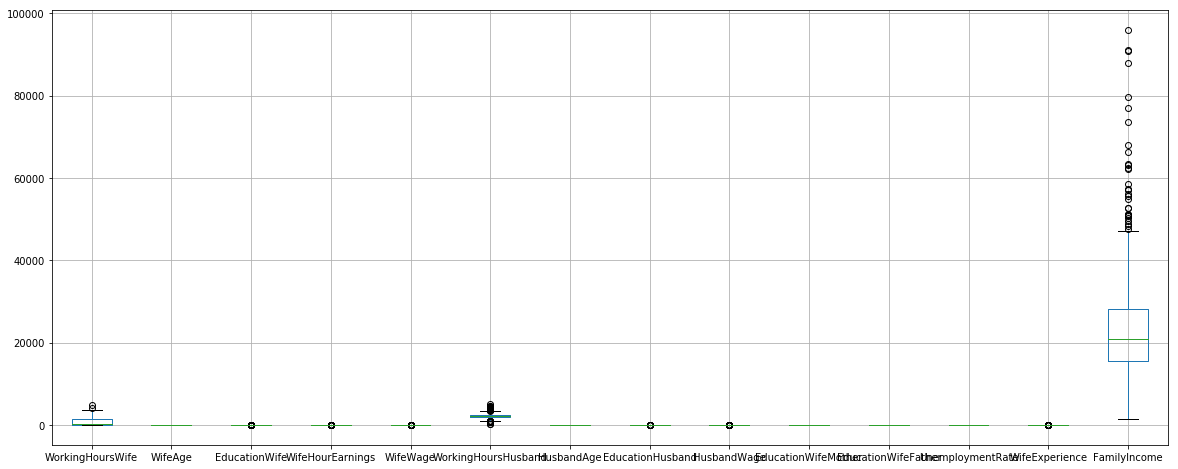

In [38]:
plt.figure(figsize=(20,8))
income.boxplot();

In [59]:
IQR = 28200.000000 - 15428.000000
IQR

12772.0

In [60]:
q1 = np.percentile(income['FamilyIncome'],25)
q1

15428.0

In [61]:
q3 = np.percentile(income['FamilyIncome'],75)
q3

28200.0

In [62]:
iqr = q3-q1
iqr

12772.0

In [63]:
upperlimit =q3 + (1.5*iqr)
upperlimit

47358.0

In [64]:

income.drop(income[income['FamilyIncome'] > upperlimit].index, inplace = True) 
income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 722 entries, 0 to 752
Data columns (total 14 columns):
WorkingHoursWife       722 non-null int64
WifeAge                722 non-null int64
EducationWife          722 non-null int64
WifeHourEarnings       722 non-null float64
WifeWage               722 non-null float64
WorkingHoursHusband    722 non-null int64
HusbandAge             722 non-null int64
EducationHusband       722 non-null int64
HusbandWage            722 non-null float64
EducationWifeMother    722 non-null int64
EducationWifeFather    722 non-null int64
UnemploymentRate       722 non-null float64
WifeExperience         722 non-null int64
FamilyIncome           722 non-null int64
dtypes: float64(4), int64(10)
memory usage: 84.6 KB


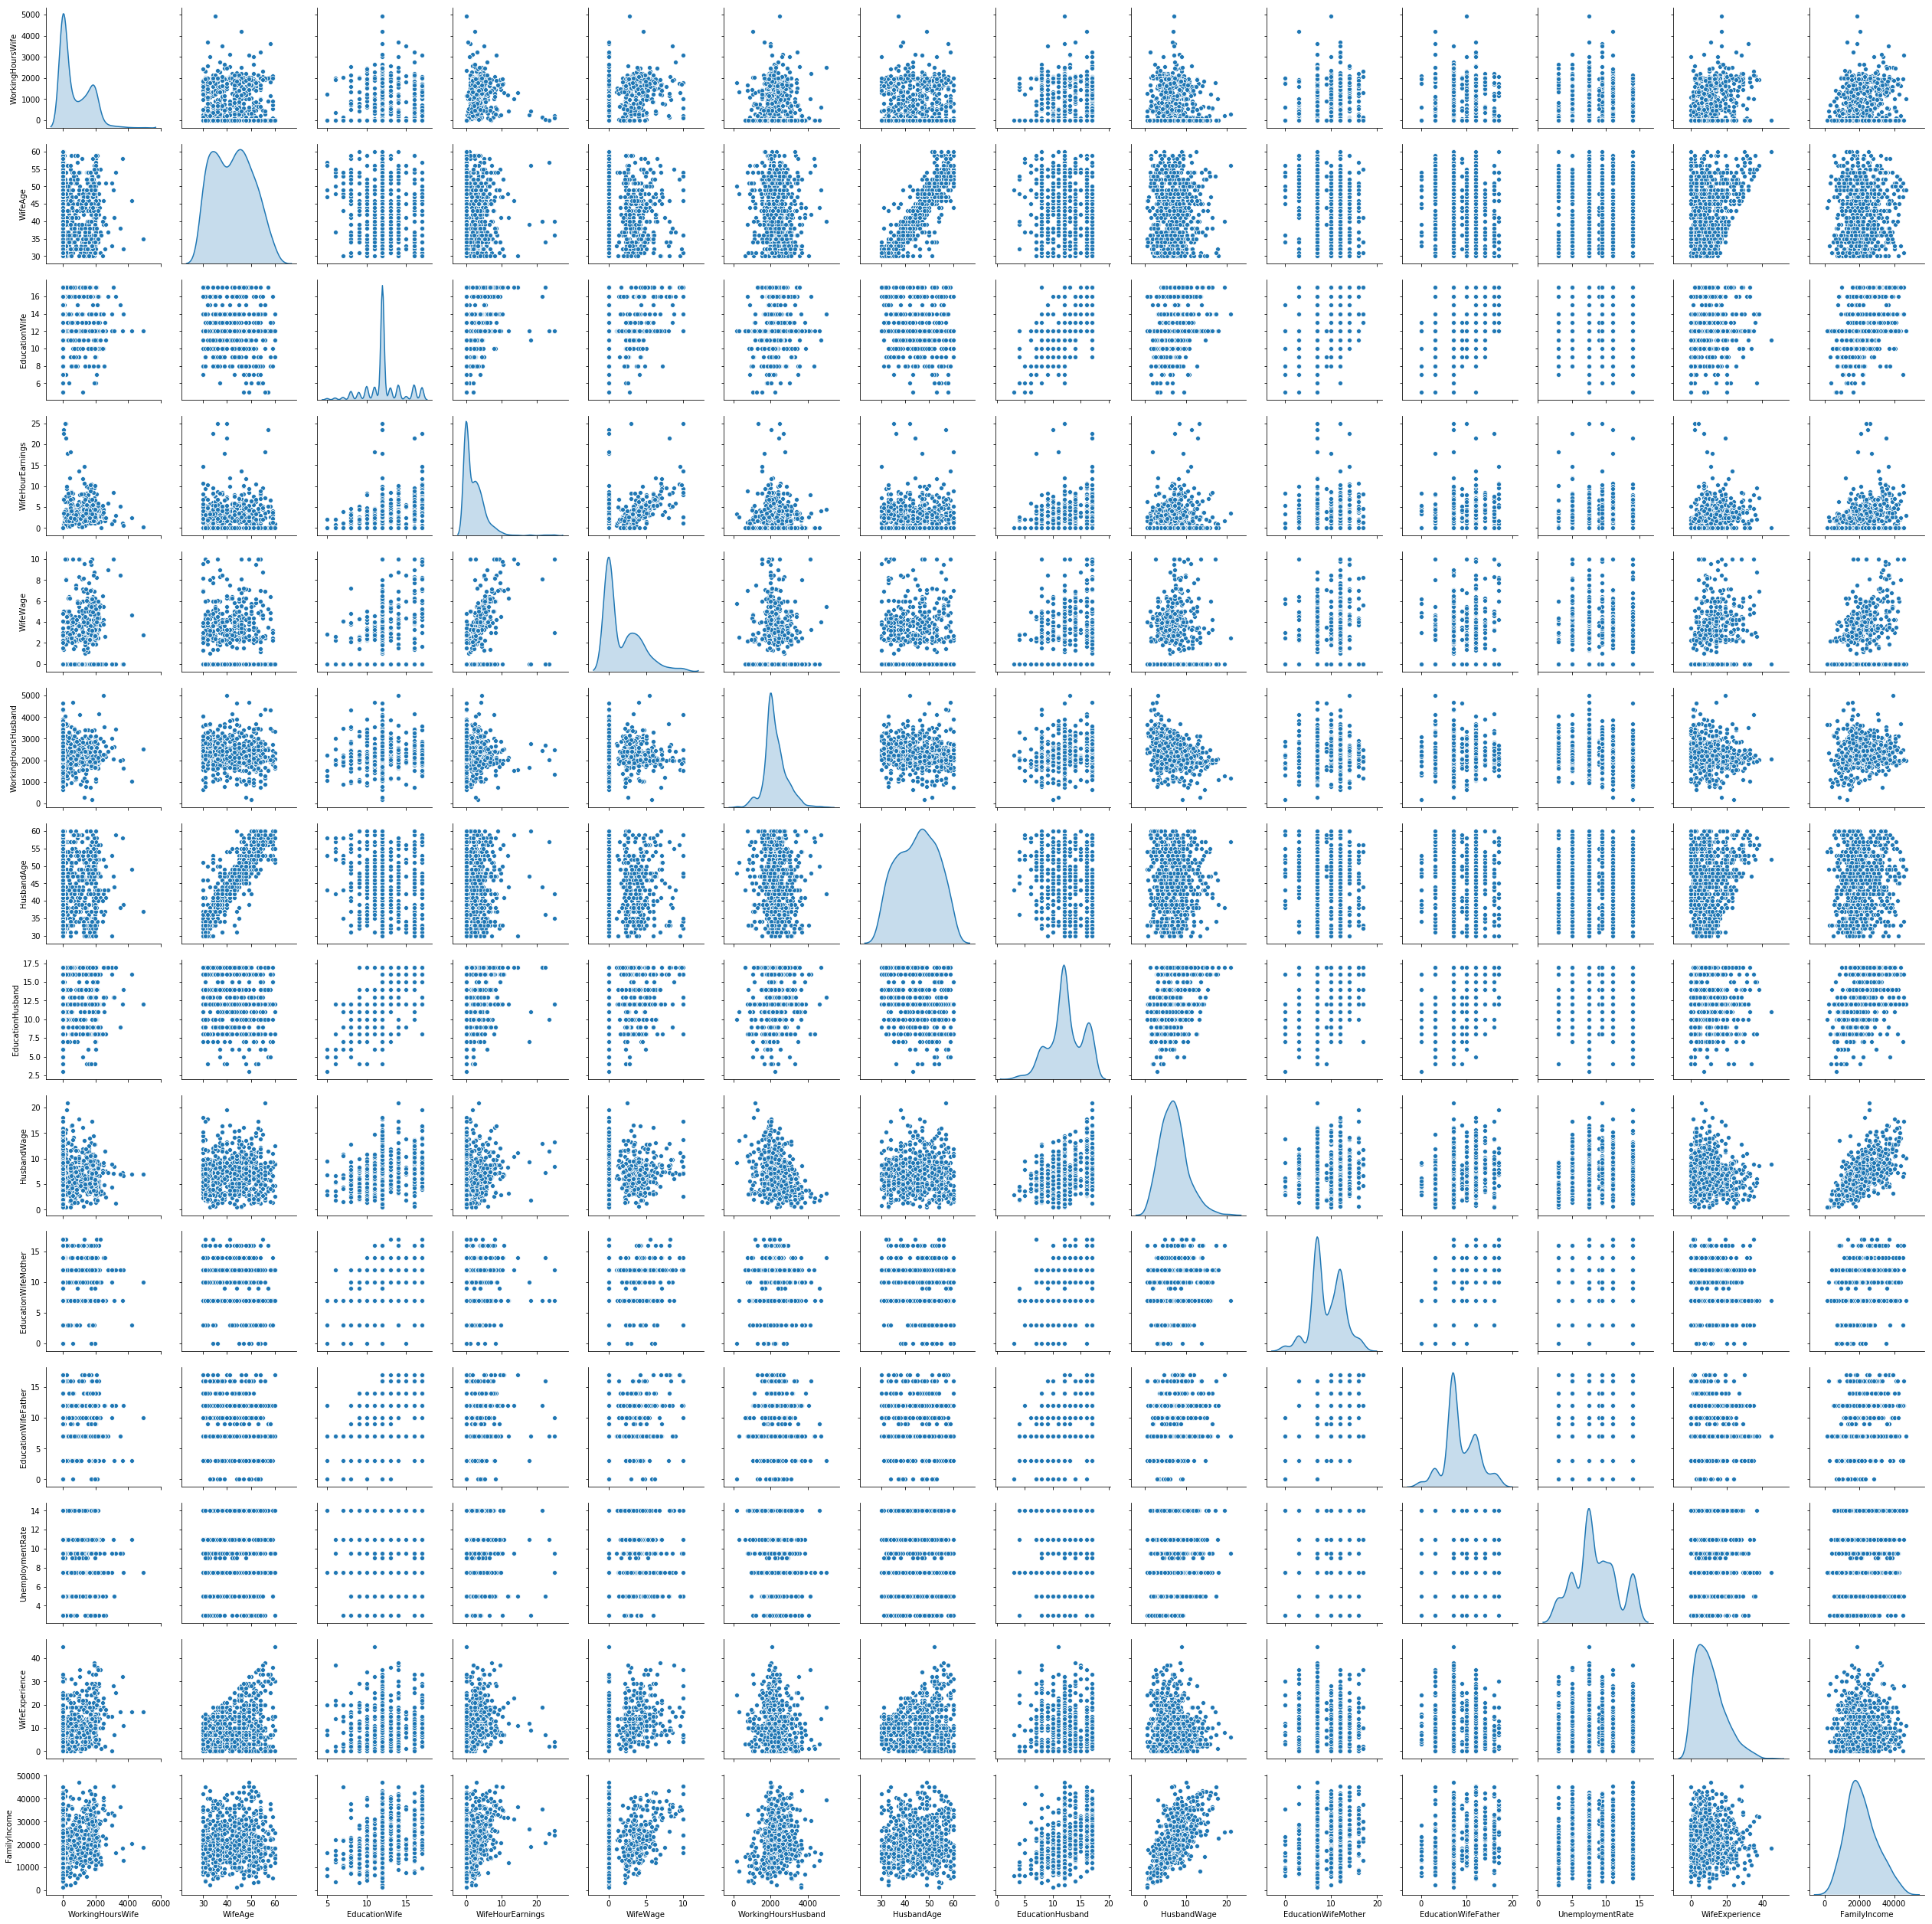

In [65]:
sns.pairplot(income,diag_kind='kde');

**2.2) Is there evidence of multicollinearity? Showcase your analysis**

In [66]:
corr = income.corr()
corr

,WorkingHoursWife,WifeAge,EducationWife,WifeHourEarnings,WifeWage,WorkingHoursHusband,HusbandAge,EducationHusband,HusbandWage,EducationWifeMother,EducationWifeFather,UnemploymentRate,WifeExperience,FamilyIncome
WorkingHoursWife,1.000000,-0.040819,0.109159,0.412419,0.599969,-0.058813,-0.037727,-0.008679,-0.084531,0.055782,0.015512,-0.053618,0.404080,0.225837
WifeAge,-0.040819,1.000000,-0.119014,-0.039861,-0.060132,-0.074725,0.887023,-0.165648,0.020764,-0.245489,-0.158934,0.072136,0.336322,0.064080
EducationWife,0.109159,-0.119014,1.000000,0.316622,0.272893,0.062759,-0.128147,0.601336,0.273875,0.442408,0.434443,0.071892,0.074919,0.359638
WifeHourEarnings,0.412419,-0.039861,0.316622,1.000000,0.643872,-0.055266,-0.037277,0.124364,0.082792,0.101946,0.113284,0.007043,0.252299,0.289381
WifeWage,0.599969,-0.060132,0.272893,0.643872,1.000000,-0.074816,-0.058878,0.108568,0.053431,0.093419,0.118014,0.017369,0.339764,0.288754
WorkingHoursHusband,-0.058813,-0.074725,0.062759,-0.055266,-0.074816,1.000000,-0.086957,0.099635,-0.323029,0.048955,0.024806,-0.169642,-0.100519,0.122108
HusbandAge,-0.037727,0.887023,-0.128147,-0.037277,-0.058878,-0.086957,1.000000,-0.192633,0.026089,-0.231706,-0.129519,0.049245,0.270104,0.062441
EducationHusband,-0.008679,-0.165648,0.601336,0.124364,0.108568,0.099635,-0.192633,1.000000,0.404725,0.328390,0.359650,0.057551,-0.030549,0.408052
HusbandWage,-0.084531,0.020764,0.273875,0.082792,0.053431,-0.323029,0.026089,0.404725,1.000000,0.156995,0.215039,0.169077,-0.106738,0.648799
EducationWifeMother,0.055782,-0.245489,0.442408,0.101946,0.093419,0.048955,-0.231706,0.328390,0.156995,1.000000,0.571262,0.014359,-0.077181,0.196521


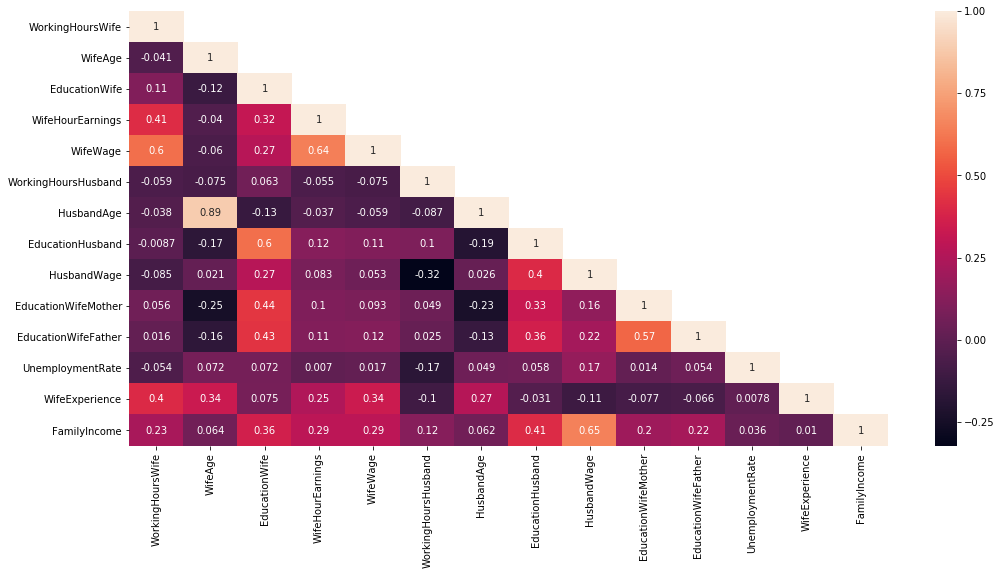

In [67]:
plt.figure(figsize=(17,8))
sns.heatmap(corr,annot=True,mask=np.triu(corr,+1));

In [70]:
Xtrial = income.drop(['FamilyIncome','HusbandAge', 'EducationWifeFather', 'WifeHourEarnings','EducationWife'] ,axis=1, )

In [71]:
X_trial= Xtrial.apply(zscore)
X_trial.head()

,WorkingHoursWife,WifeAge,WifeWage,WorkingHoursHusband,EducationHusband,HusbandWage,EducationWifeMother,UnemploymentRate,WifeExperience
0,0.994039,-1.299182,0.336726,0.753466,-0.133082,-0.916740,0.822551,-1.154288,0.404171
1,1.046702,-1.546482,0.336726,0.083956,-1.140968,0.436160,-0.660670,0.773382,-0.703974
2,1.417638,-0.928232,0.916646,1.365781,-0.133082,-1.054121,0.822551,-1.154288,0.527298
3,-0.327135,-1.051882,0.587051,-0.572097,-0.805006,-1.066078,-0.660670,-1.154288,-0.580847
4,0.945954,-1.422832,0.733074,-0.437522,-0.133082,0.913943,0.822551,0.291464,-0.457719


In [72]:
X_1trial =sm.add_constant(X_trial)

In [74]:
Y = income['FamilyIncome'].copy()

In [75]:
model = sm.OLS(Y,X_1trial).fit(normalize = True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           FamilyIncome   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     162.3
Date:                Sun, 21 Feb 2021   Prob (F-statistic):          6.31e-166
Time:                        19:46:57   Log-Likelihood:                -7182.4
No. Observations:                 722   AIC:                         1.438e+04
Df Residuals:                     712   BIC:                         1.443e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 2.14e+04    189.607    112.887      0.000     2.1e+04    2.18e+04
WorkingHoursWife     2232.1971    250.274      8.919      0.000    1740.833    2723.561
WifeAge              1244.2279    215.488      5.774      0.000     821.160    1667.296
WifeWage             1290.8843    244.233      5.285      0.000     811.382    1770.387
WorkingHoursHusband  3361.3119    212.423     15.824      0.000    2944.261    3778.363
EducationHusband      555.8178    227.680      2.441      0.015     108.814    1002.822
HusbandWage          6611.3719    233.560     28.307      0.000    6152.823    7069.920
EducationWifeMother   371.1975    205.947      1.802      0.072     -33.138     775.533
UnemploymentRate     -252.4594    194.753     -1.296      0.195    -634.818     129.899
WifeExperience       -576.4574    231.584     -2.489      0.013   -1031.127    -121.788
==============================================================================
Omnibus:                      109.513   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              216.663
Skew:                           0.880   Prob(JB):                     8.96e-48
Kurtosis:                       5.026   Cond. No.                         2.31
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is multicollinearity among the Independant Variables - HusbandAge-WifeAge, WifeWage-WifeHourEarnings, EducationHusband-EducationWife,WifeWage-WorkingHoursWife .
 
We have run a trial Liner Regression model droping the multicolliner variables and we come across the fact that dropping these does not result in an improvement in the Rsquared values, infact the Rsquared value drops from 0.672 without dropping these multicolliner variable to 0.668 post dropping the multicollinear variables.

**2.3) Perform Multiple Linear Regression (using the 'statsmodels' library) and comment on the model thus built.**

In [79]:
X = income.drop(['FamilyIncome',] ,axis=1)

In [80]:
X= X.apply(zscore)
X.head()

,WorkingHoursWife,WifeAge,EducationWife,WifeHourEarnings,WifeWage,WorkingHoursHusband,HusbandAge,EducationHusband,HusbandWage,EducationWifeMother,EducationWifeFather,UnemploymentRate,WifeExperience
0,0.994039,-1.299182,-0.092314,0.316175,0.336726,0.753466,-1.369972,-0.133082,-0.916740,0.822551,-0.493173,-1.154288,0.404171
1,1.046702,-1.546482,-0.092314,-0.296334,0.336726,0.083956,-1.862561,-1.140968,0.436160,-0.660670,-0.493173,0.773382,-0.703974
2,1.417638,-0.928232,-0.092314,0.687557,0.916646,1.365781,-0.631088,-0.133082,-1.054121,0.822551,-0.493173,-1.154288,0.527298
3,-0.327135,-1.051882,-0.092314,-0.387473,0.587051,-0.572097,0.969828,-0.805006,-1.066078,-0.660670,-0.493173,-1.154288,-0.580847
4,0.945954,-1.422832,0.802330,0.701989,0.733074,-0.437522,-1.616266,-0.133082,0.913943,0.822551,1.488144,0.291464,-0.457719


In [81]:
Y = income['FamilyIncome'].copy()

In [82]:
# This adds the constant term beta0 to the Multiple Linear Regression.

X_1 =sm.add_constant(X)

In [83]:
model = sm.OLS(Y,X_1).fit(normalize = True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           FamilyIncome   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     115.6
Date:                Sun, 21 Feb 2021   Prob (F-statistic):          3.81e-165
Time:                        19:49:46   Log-Likelihood:                -7174.0
No. Observations:                 722   AIC:                         1.438e+04
Df Residuals:                     708   BIC:                         1.444e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 2.14e+04    187.941    113.887      0.000     2.1e+04    2.18e+04
WorkingHoursWife     2209.0186    248.761      8.880      0.000    1720.622    2697.415
WifeAge               888.5106    424.352      2.094      0.037      55.372    1721.649
EducationWife         342.9611    266.069      1.289      0.198    -179.417     865.339
WifeHourEarnings      860.7636    251.560      3.422      0.001     366.870    1354.657
WifeWage              704.9048    285.171      2.472      0.014     145.024    1264.786
WorkingHoursHusband  3349.1397    210.895     15.881      0.000    2935.086    3763.193
HusbandAge            398.0443    412.125      0.966      0.334    -411.090    1207.178
EducationHusband      384.1576    259.208      1.482      0.139    -124.751     893.066
HusbandWage          6549.1833    232.469     28.172      0.000    6092.771    7005.595
EducationWifeMother   248.6066    242.396      1.026      0.305    -227.295     724.508
EducationWifeFather    12.8201    239.619      0.054      0.957    -457.629     483.269
UnemploymentRate     -248.4391    193.498     -1.284      0.200    -628.337     131.459
WifeExperience       -620.4959    230.815     -2.688      0.007   -1073.660    -167.332
==============================================================================
Omnibus:                      111.144   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              227.053
Skew:                           0.880   Prob(JB):                     4.97e-50
Kurtosis:                       5.110   Cond. No.                         5.29
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R squared value is 0.680
the adjusted R squared value is 0.674.
In case of multiple Linear regression models we should always consider the Adj. RSquared value as we are working with many independant variables. It gives us what is the variation that is explained by these independant variables for the dependant variable under consideration.
The Probabilty value indicates that the model is significant with a palue of 3.81e-165.

Higher the Rsquared value the better the model fits the data. R-squared explains to what extent the variance of one variable explains the variance of the second variable

In [84]:
print("The RSQ value is ", model.rsquared)

The RSQ value is  0.6798025447316409


**2.4) Perform Principal Component Analysis (on the predictor variables) and extract the Principal Components. Comment on the reason behind choosing the number of Principal Components.**

In [85]:
y_pred = model.predict(X_1)
print(y_pred)

0      19080.778683
1      24324.959824
2      22443.279442
3      11450.937282
4      27886.680017
5      19022.495594
6      21222.967761
7      26480.980541
8      14590.323264
9      20119.964281
10     30809.249234
11     28951.343919
12     19381.054901
13     23007.839434
14     31996.628436
15     22217.223253
16     20945.300100
17     20169.912941
18     22622.639293
19     18683.528751
20     30508.295318
21     15836.743911
22     26747.434958
23     18079.123515
24     16301.720624
25     34358.537748
26     22327.351604
27     25506.721343
28     25255.450837
29     17258.565199
           ...     
719     4453.507304
720    11579.744253
722    17959.309782
723     9843.946080
724     7926.254549
725    22054.247962
726    24572.620238
729    31092.312251
731    13635.053217
732    10400.327212
733    18824.309518
734    27406.017083
735    13163.990583
736    10591.740060
737     7620.088164
738    37776.371631
739    20560.340736
740      560.356096
741    30296.904574


In [86]:
mse = (np.sum(np.square(Y - y_pred)))/income.shape[0]
mse

25007936.8369979

In [88]:
Lr_1 = np.sqrt(mse)
print("The Root Mean Square Error is ", Lr_1)

The Root Mean Square Error is  5000.793620716406


In [89]:
# Step 1
# All variables are on the same scale.
# To standardise the process scaling is done.

data_scaled = X.apply(zscore)
data_scaled.head()

,WorkingHoursWife,WifeAge,EducationWife,WifeHourEarnings,WifeWage,WorkingHoursHusband,HusbandAge,EducationHusband,HusbandWage,EducationWifeMother,EducationWifeFather,UnemploymentRate,WifeExperience
0,0.994039,-1.299182,-0.092314,0.316175,0.336726,0.753466,-1.369972,-0.133082,-0.916740,0.822551,-0.493173,-1.154288,0.404171
1,1.046702,-1.546482,-0.092314,-0.296334,0.336726,0.083956,-1.862561,-1.140968,0.436160,-0.660670,-0.493173,0.773382,-0.703974
2,1.417638,-0.928232,-0.092314,0.687557,0.916646,1.365781,-0.631088,-0.133082,-1.054121,0.822551,-0.493173,-1.154288,0.527298
3,-0.327135,-1.051882,-0.092314,-0.387473,0.587051,-0.572097,0.969828,-0.805006,-1.066078,-0.660670,-0.493173,-1.154288,-0.580847
4,0.945954,-1.422832,0.802330,0.701989,0.733074,-0.437522,-1.616266,-0.133082,0.913943,0.822551,1.488144,0.291464,-0.457719


In [92]:
# Step 2 Taking covariance of the scaled data

data_scaled.cov()

,WorkingHoursWife,WifeAge,EducationWife,WifeHourEarnings,WifeWage,WorkingHoursHusband,HusbandAge,EducationHusband,HusbandWage,EducationWifeMother,EducationWifeFather,UnemploymentRate,WifeExperience
WorkingHoursWife,1.001387,-0.040875,0.109310,0.412991,0.600801,-0.058894,-0.037779,-0.008691,-0.084648,0.055859,0.015534,-0.053693,0.404640
WifeAge,-0.040875,1.001387,-0.119179,-0.039917,-0.060215,-0.074829,0.888253,-0.165878,0.020793,-0.245830,-0.159154,0.072236,0.336789
EducationWife,0.109310,-0.119179,1.001387,0.317061,0.273271,0.062846,-0.128324,0.602171,0.274255,0.443022,0.435045,0.071992,0.075023
WifeHourEarnings,0.412991,-0.039917,0.317061,1.001387,0.644765,-0.055342,-0.037328,0.124536,0.082907,0.102087,0.113441,0.007052,0.252649
WifeWage,0.600801,-0.060215,0.273271,0.644765,1.001387,-0.074920,-0.058960,0.108719,0.053505,0.093549,0.118178,0.017393,0.340235
WorkingHoursHusband,-0.058894,-0.074829,0.062846,-0.055342,-0.074920,1.001387,-0.087078,0.099773,-0.323477,0.049023,0.024840,-0.169878,-0.100658
HusbandAge,-0.037779,0.888253,-0.128324,-0.037328,-0.058960,-0.087078,1.001387,-0.192900,0.026125,-0.232027,-0.129699,0.049313,0.270479
EducationHusband,-0.008691,-0.165878,0.602171,0.124536,0.108719,0.099773,-0.192900,1.001387,0.405287,0.328846,0.360149,0.057630,-0.030591
HusbandWage,-0.084648,0.020793,0.274255,0.082907,0.053505,-0.323477,0.026125,0.405287,1.001387,0.157213,0.215337,0.169311,-0.106886
EducationWifeMother,0.055859,-0.245830,0.443022,0.102087,0.093549,0.049023,-0.232027,0.328846,0.157213,1.001387,0.572054,0.014379,-0.077288


In [93]:
# Step 3

eig_vls, eig_vecs = np.linalg.eig(data_scaled.cov())

print('Eigen Values \n', eig_vls )
print('\n Eigen Vectors \n', eig_vecs )

Eigen Values 
 [3.00390623 2.38250747 1.79327513 1.28189856 0.89609734 0.8702999
 0.69660437 0.10754193 0.52679295 0.43608896 0.4129681  0.29519783
 0.31485174]

 Eigen Vectors 
 [[-1.85608580e-01  4.13139031e-01  2.94169372e-01 -4.73059600e-02
   1.06215253e-01  6.72261942e-02 -1.87245572e-01 -2.87626249e-02
  -6.06672412e-01  2.86773925e-01 -1.97752565e-01  4.04355366e-01
   3.87666178e-02]
 [ 2.60299591e-01  3.45908730e-01 -4.43210085e-01  2.61900200e-01
   8.19993338e-04  1.69437589e-02  1.15106911e-01 -7.17425702e-01
  -4.73740103e-02  9.80223571e-02 -2.15330473e-02 -2.50927711e-02
  -7.98835320e-02]
 [-4.37473735e-01  2.26322513e-02 -1.93017678e-01  1.93853090e-01
  -1.63878314e-01 -1.41002067e-01 -9.17342235e-02 -5.90305378e-03
   3.47282612e-01  3.80104270e-01 -2.57380477e-01  3.19787202e-02
   5.87988225e-01]
 [-2.86453140e-01  3.65532750e-01  1.48532509e-01 -7.61989220e-02
  -1.53209731e-01 -6.84760445e-02  5.15306537e-01 -4.81275603e-03
   3.87555316e-01 -1.10469481e-01  2.1

In [94]:
# Step 4

tot = sum(eig_vls)
var_expl = [(i/tot)*100 for i in sorted(eig_vls, reverse = True)]
print("The variance explained by each of the Eigen Values is " , var_expl)

The variance explained by each of the Eigen Values is  [23.074966869072462, 18.301596924400233, 13.775318194938102, 9.84710060734952, 6.883509271607112, 6.68534226881492, 5.35107338077084, 4.046640948167695, 3.349884302002882, 3.1722778971963947, 2.4185819888436075, 2.2676074728220077, 0.8260998740142179]


In [95]:
cum_var_expl = np.cumsum(var_expl)
print("The cumulative variance explained is " , cum_var_expl)

The cumulative variance explained is  [ 23.07496687  41.37656379  55.15188199  64.9989826   71.88249187
  78.56783414  83.91890752  87.96554847  91.31543277  94.48771066
  96.90629265  99.17390013 100.        ]


Text(0.5, 1.0, 'Eigen Values Vs Principle Components')

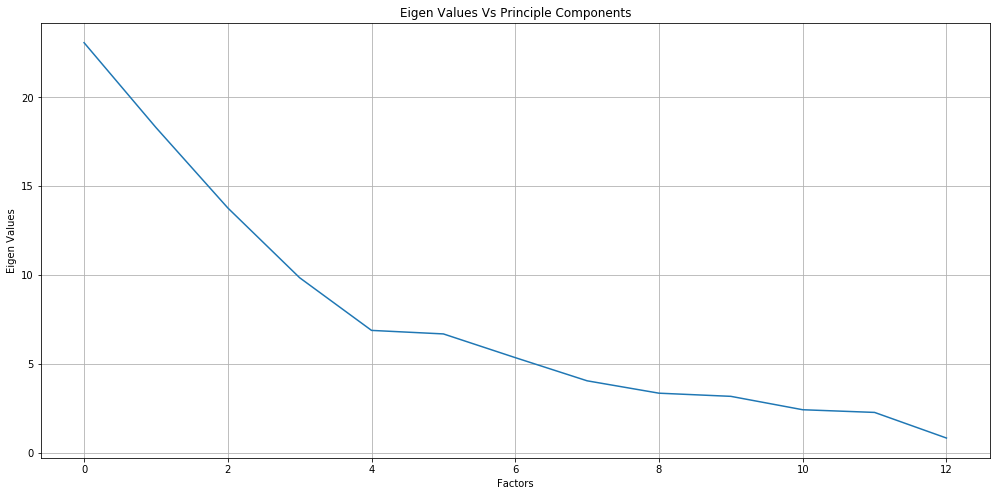

In [96]:
# Step 5 Plotting the Variation Explained

plt.figure(figsize = (17,8))
plt.plot(var_expl)
plt.grid()
plt.ylabel("Eigen Values")
plt.xlabel("Factors")
plt.title("Eigen Values Vs Principle Components")

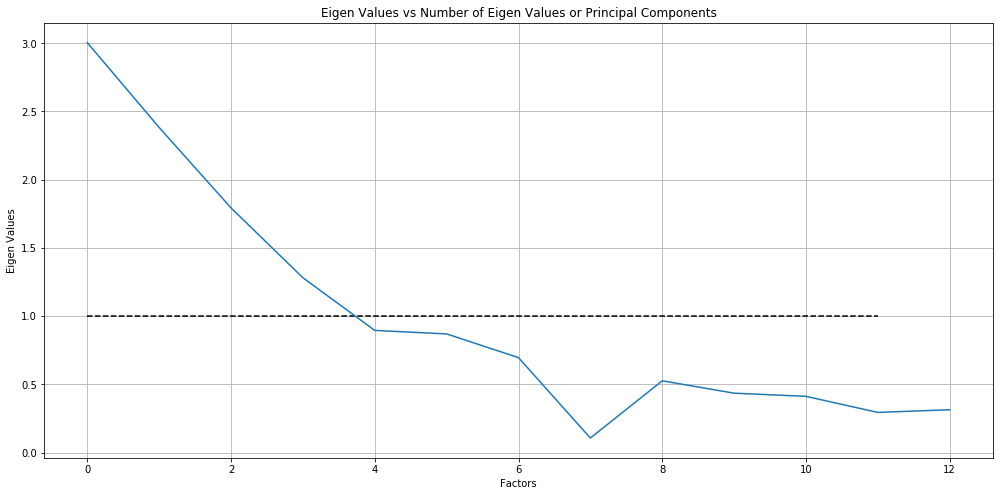

In [97]:
plt.figure(figsize=(17,8))
plt.plot(eig_vls)
plt.grid()
plt.ylabel('Eigen Values')
plt.xlabel('Factors')
plt.hlines(y=1,xmin=0,xmax=11,linestyles='dashed')
plt.title('Eigen Values vs Number of Eigen Values or Principal Components');

In [101]:
print('From the above plot, we can see that the number of components that we can probably take is 6.\n'
      'We also see that if we take 6 components the total amount of variance explained is',cum_var_expl[5],'%')

From the above plot, we can see that the number of components that we can probably take is 6.
We also see that if we take 6 components the total amount of variance explained is 78.56783413618236 %


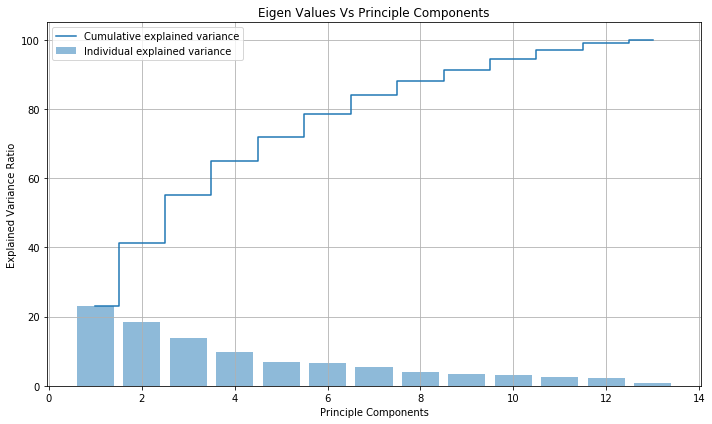

In [102]:
plt.figure(figsize = (10,6))
plt.bar(range(1,eig_vls.size+1),var_expl, alpha=0.5, align= 'center', label='Individual explained variance')
plt.step(range(1, eig_vls.size+1),cum_var_expl, where='mid', label='Cumulative explained variance')
plt.ylabel("Explained Variance Ratio")
plt.xlabel("Principle Components")
plt.title("Eigen Values Vs Principle Components")
plt.legend(loc ='best')
plt.tight_layout()
plt.grid()
plt.show()

**Automated Scree plot given by Python.**

In [ ]:
rcParams['figure.figsize'] = 17, 8

model=Factor(X).fit()
model.plot_scree()
plt.grid()
plt.show()

In [104]:
pc = PCA(X,
         ncomp=6,
         standardize=True,
         normalize=True,
         missing=None,
         method="eig")

In [105]:
df_comp = pc.loadings.T
df_comp

,WorkingHoursWife,WifeAge,EducationWife,WifeHourEarnings,WifeWage,WorkingHoursHusband,HusbandAge,EducationHusband,HusbandWage,EducationWifeMother,EducationWifeFather,UnemploymentRate,WifeExperience
comp_0,-0.185609,0.260300,-0.437474,-0.286453,-0.291955,-0.004509,0.259468,-0.383393,-0.214089,-0.376747,-0.367604,-0.039920,-0.016857
comp_1,0.413139,0.345909,0.022632,0.365533,0.419914,-0.137476,0.332608,-0.108995,-0.038103,-0.145612,-0.111886,0.026729,0.471077
comp_2,0.294169,-0.443210,-0.193018,0.148533,0.212078,0.217714,-0.440620,-0.241995,-0.437117,-0.095851,-0.195532,-0.272235,-0.004898
comp_3,-0.047306,0.261900,0.193853,-0.076199,-0.103432,0.647449,0.256136,0.122515,-0.368123,0.204834,0.204185,-0.372831,0.130825
comp_4,0.106215,0.000820,-0.163878,-0.153210,-0.044261,-0.166597,0.021348,-0.432409,-0.353566,0.471689,0.437292,0.413785,0.106303
comp_5,-0.067226,-0.016944,0.141002,0.068476,0.043732,0.445790,-0.070069,0.169938,-0.189217,-0.228047,-0.207243,0.778001,0.012236


In [106]:
Y_factors = pc.factors
Y_factors.head()

,comp_0,comp_1,comp_2,comp_3,comp_4,comp_5
0,-0.018739,-0.004794,0.070496,0.017927,0.000821,-0.016655
1,-0.006409,-0.018202,0.053274,-0.060004,0.006249,0.026935
2,-0.019630,0.017099,0.070650,0.039019,-0.001612,-0.006087
3,0.022434,-0.000476,0.028937,-0.000623,-0.008369,-0.035306
4,-0.058768,-0.012320,0.022706,-0.037412,0.027984,-0.015904


In [107]:
## Renamed the factors

Y_factors.rename(columns={"comp_0": "Education", "comp_1":"WifeInfo", "comp_2": "Age_Wage", "comp_3":"WorkingHours", "comp_4":"Education_Unemployement", "comp_5":"WorkingHours_Unemployment"}, inplace=True)

In [108]:
Y_factors.head()

,Education,WifeInfo,Age_Wage,WorkingHours,Education_Unemployement,WorkingHours_Unemployment
0,-0.018739,-0.004794,0.070496,0.017927,0.000821,-0.016655
1,-0.006409,-0.018202,0.053274,-0.060004,0.006249,0.026935
2,-0.019630,0.017099,0.070650,0.039019,-0.001612,-0.006087
3,0.022434,-0.000476,0.028937,-0.000623,-0.008369,-0.035306
4,-0.058768,-0.012320,0.022706,-0.037412,0.027984,-0.015904


In [110]:
Y_factors_corr = Y_factors.corr()
Y_factors_corr

,Education,WifeInfo,Age_Wage,WorkingHours,Education_Unemployement,WorkingHours_Unemployment
Education,1.000000e+00,2.710505e-17,-5.719166e-17,-1.369347e-16,4.876199e-17,-1.090707e-16
WifeInfo,2.710505e-17,1.000000e+00,-1.119439e-17,1.212138e-16,-5.838768e-17,-1.409463e-17
Age_Wage,-5.719166e-17,-1.119439e-17,1.000000e+00,-2.573218e-16,2.018022e-16,-1.024571e-17
WorkingHours,-1.369347e-16,1.212138e-16,-2.573218e-16,1.000000e+00,1.934318e-16,-9.866240e-17
Education_Unemployement,4.876199e-17,-5.838768e-17,2.018022e-16,1.934318e-16,1.000000e+00,-7.424752e-17
WorkingHours_Unemployment,-1.090707e-16,-1.409463e-17,-1.024571e-17,-9.866240e-17,-7.424752e-17,1.000000e+00


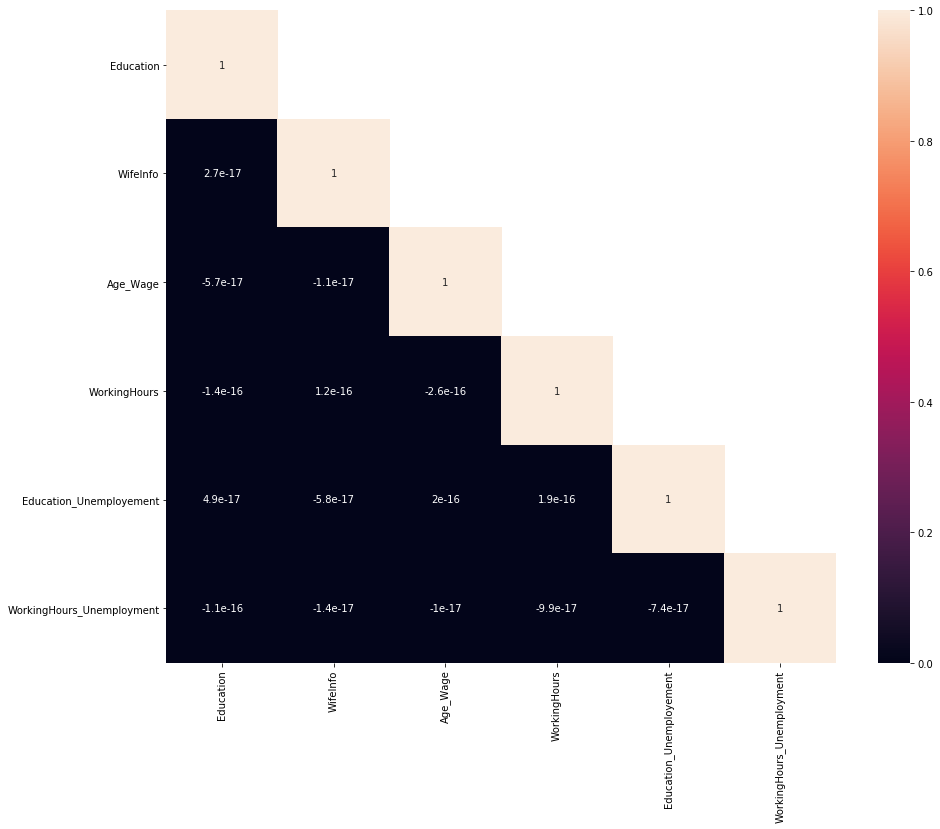

In [111]:
sns.heatmap(Y_factors_corr,annot=True,mask=np.triu(Y_factors_corr,+1));

**2.5) Perform Multiple Linear Regression with 'FamilyIncome' as the dependent variable and the Principal Components extracted as the independent variables.**

In [112]:
# This adds the constant term beta0 to the Multiple Linear Regression.

X_pca=sm.add_constant(Y_factors)

In [113]:
model_pca = sm.OLS(Y,X_pca).fit()
model_pca.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           FamilyIncome   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     86.23
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           3.42e-81
Time:                        20:27:06   Log-Likelihood:                -7388.6
No. Observations:                 722   AIC:                         1.479e+04
Df Residuals:                     715   BIC:                         1.482e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       2.14e+04    251.745     85.023      0.000    2.09e+04    2.19e+04
Education                  -1.08e+05   6764.396    -15.964      0.000   -1.21e+05   -9.47e+04
WifeInfo                   3.657e+04   6764.396      5.406      0.000    2.33e+04    4.99e+04
Age_Wage                  -6.798e+04   6764.396    -10.049      0.000   -8.13e+04   -5.47e+04
WorkingHours                841.7976   6764.396      0.124      0.901   -1.24e+04    1.41e+04
Education_Unemployement    -7.78e+04   6764.396    -11.502      0.000   -9.11e+04   -6.45e+04
WorkingHours_Unemployment   138.3909   6764.396      0.020      0.984   -1.31e+04    1.34e+04
==============================================================================
Omnibus:                       65.936   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.867
Skew:                           0.695   Prob(JB):                     1.13e-20
Kurtosis:                       4.060   Cond. No.                         26.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [114]:
print('The Rsq value is',model_pca.rsquared)

The Rsq value is 0.41981446105514675


In [115]:
y_pred_pca = model_pca.predict(X_pca)
print(y_pred_pca)

0      18409.226375
1      17276.265734
2      19504.135348
3      17642.873187
4      23545.219975
5      22905.611611
6      24451.080863
7      22520.704394
8      13767.181919
9      22467.446374
10     23662.251801
11     24317.655016
12     20026.541164
13     19621.907194
14     27784.000715
15     18732.349905
16     21590.466151
17     20433.209990
18     21742.484595
19     19604.538319
20     25434.817516
21     18929.873566
22     29239.809894
23     26970.399864
24     17441.380310
25     33162.402703
26     27846.819609
27     24073.675465
28     30440.293979
29     19852.786765
           ...     
719    10448.361984
720    19686.021831
722    26770.699141
723    13576.055699
724     5169.880753
725    20039.911334
726    27133.719872
729    28705.253482
731    20274.750093
732    17228.603268
733    20940.689926
734    27236.569471
735    16888.547337
736    16229.204168
737    15952.766120
738    29959.858138
739    19894.366701
740    16322.013947
741    22815.488159


In [116]:
y_pred_pca = model_pca.fittedvalues
print(y_pred_pca)

0      18409.226375
1      17276.265734
2      19504.135348
3      17642.873187
4      23545.219975
5      22905.611611
6      24451.080863
7      22520.704394
8      13767.181919
9      22467.446374
10     23662.251801
11     24317.655016
12     20026.541164
13     19621.907194
14     27784.000715
15     18732.349905
16     21590.466151
17     20433.209990
18     21742.484595
19     19604.538319
20     25434.817516
21     18929.873566
22     29239.809894
23     26970.399864
24     17441.380310
25     33162.402703
26     27846.819609
27     24073.675465
28     30440.293979
29     19852.786765
           ...     
719    10448.361984
720    19686.021831
722    26770.699141
723    13576.055699
724     5169.880753
725    20039.911334
726    27133.719872
729    28705.253482
731    20274.750093
732    17228.603268
733    20940.689926
734    27236.569471
735    16888.547337
736    16229.204168
737    15952.766120
738    29959.858138
739    19894.366701
740    16322.013947
741    22815.488159


In [117]:
mse_pca = (np.sum(np.square(Y - y_pred_pca)))/income.shape[0]
mse_pca

45313424.80380489

In [118]:
Lr_pca = np.sqrt(mse_pca)

print("The Root Mean Square Error (RMSE) of the model whose predictor variables have been reduced by PCA is",Lr_pca)

The Root Mean Square Error (RMSE) of the model whose predictor variables have been reduced by PCA is 6731.524701269756


In [119]:
print("The Root Mean Square Error (RMSE) of the model with all the predictor variables is",Lr_1,"\nThe Root Mean Square Error (RMSE) of the model whose predictor variables have been reduced by PCA is",Lr_pca)

The Root Mean Square Error (RMSE) of the model with all the predictor variables is 5000.793620716406 
The Root Mean Square Error (RMSE) of the model whose predictor variables have been reduced by PCA is 6731.524701269756


**2.6) Comment on the Model thus built using the Principal Components and with 'FamilyIncome'.**

Successfully reduced the components from 13 to 6.

The Root Mean Square Error (RMSE) of the model with all the predictor variables is 5000.79and The Root Mean Square Error (RMSE) of the model whose predictor variables have been reduced by PCA is 6731.52. In-order to check whether we have performed the factor analysis on a factorable dataset, we conduct Bartlett’s and KMO tests to conclude the same.

In [120]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

In [121]:
chi_square_value,p_value=calculate_bartlett_sphericity(income)
chi_square_value, p_value

(4254.954646692446, 0.0)

In Bartlett’s test, the p-value observed is 0. The test is statistically significant, indicating that the observed correlation matrix is not an identity matrix and thus we can perform factor analysis on the same, therefore the steps adopted are correct.

In [123]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(income)

In [124]:
kmo_model

0.6272940054445723

Since the KMO value obtained passes threshold criterion of 0.6, we are free to proceed with our dimension reduction.

We observe that though the components are reduced from 13 to 6, the RMSE score has still increased by 1731 units. Since the RMSE is increased and the R-squared, adjusted R-squared values are indicating a considerable dip, we conclude that the model is not performing as expected.

**2.7) Mention the business implication and interpretation of the models.**

**Interpretation :**

The dataset consisted of income of various households and there were many factors influencing the same. The influencing factors i.e independent variables were analyzed for correlation amongst one another (multicollinearity) in-order to improve the model performance by reducing the number of insignificant factors. The final model result suggests that the p-value is the highest for component-6 i.e Unemployment, which thereby signifies that unemployment in an household is highly impacting the Family income. 
Therefore, we shall conclude that if measures are taken towards reducing the unemployment rate, the household income will show significant improvement.

**Business Implications :**

i.	Dimension reduction as a measure can be adapted in the places where volume of data is massive. 

ii.	Multicollinearity among the independent variables can be reduced for better model performance. 

iii.	Cluster profiling and segmentation

iv.	Dimension reduction is used to prepare data for another/different modeling process.